# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python.

## Setup

We first import the LensKit components we need:

In [1]:
from lenskit import batch, topn
from lenskit import crossfold as xf
from lenskit.algorithms import als, item_knn as knn
from lenskit.metrics import topn as tnmetrics

And Pandas is very useful:

In [2]:
import pandas as pd

In [3]:
%matplotlib inline

## Loading Data

We're going to use the ML-100K data set:

In [4]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])
ratings.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Defining Algorithms

Let's set up two algorithms:

In [5]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations:

In [6]:
def eval(aname, algo, train, test):
    model = algo.train(train)
    users = test.user.unique()
    # the recommend function can merge rating values
    recs = batch.recommend(algo, model, users, 100,
            topn.UnratedCandidates(train), test)
    # add the algorithm
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [7]:
all_recs = []
for train, test in xf.partition_users(ratings, 5, xf.SampleFrac(0.2)):
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

With the results in place, we can concatenate them into a single data frame:

In [8]:
all_recs = pd.concat(all_recs)
all_recs.head()

,user,rank,item,score,rating,timestamp,Algorithm
0,6,1,1449,4.975959,0.0,NaN,ItemItem
1,6,2,1398,4.693661,0.0,NaN,ItemItem
2,6,3,603,4.583224,0.0,NaN,ItemItem
3,6,4,480,4.449822,4.0,883601089.0,ItemItem
4,6,5,1642,4.422142,0.0,NaN,ItemItem


nDCG is a per-user metric. Let's compute it for each user.  The [`ndcg`](evaluation.rst#lenskit.metrics.topn.ndcg) function has two versions; the version we are using takes a vector of ratings, in order of rank, and computes the nDCG. We can apply this to the rating vector from each user's recommendations for each algorithm.  We assume that each user only appears once per algorithm.

In [9]:
user_ndcg = all_recs.groupby(['Algorithm', 'user']).rating.apply(tnmetrics.ndcg)
user_ndcg.head()

Algorithm  user
ALS        1       0.462178
           2       0.170707
           3       0.508433
           4       0.000000
           5       0.428571
Name: rating, dtype: float64

Now we have a _series_, indexed by algorithm and user, with each user's nDCG. If we want to compare the algorithms, we can take the average:

In [10]:
user_ndcg.groupby('Algorithm').mean()

Algorithm
ALS         0.287846
ItemItem    0.221686
Name: rating, dtype: float64

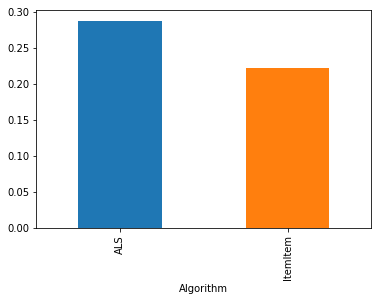

In [11]:
user_ndcg.groupby('Algorithm').mean().plot.bar()